<a href="https://colab.research.google.com/github/Santosw-Git/Classification_on_FashionMnist_dataset/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [ ]:
torch.manual_seed(42)

In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')

In [ ]:
df.shape

(60000, 785)

In [ ]:
df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [ ]:
X=df.iloc[:,1:].to_numpy()
y=df.iloc[:,0].to_numpy()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train.shape

(48000, 784)

In [ ]:
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
y_train

array([5, 7, 8, ..., 9, 4, 0])

In [ ]:
class FashionDataset(Dataset):
    def __init__(self,features,labels):

        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype=torch.long)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self,idx):
        return self.features[idx],self.labels[idx]

In [ ]:
train_dataset=FashionDataset(X_train,y_train)
test_dataset=FashionDataset(X_test,y_test)

In [ ]:
len(train_dataset)

48000

In [ ]:
# train_dataset[0]

torch.Size([784])


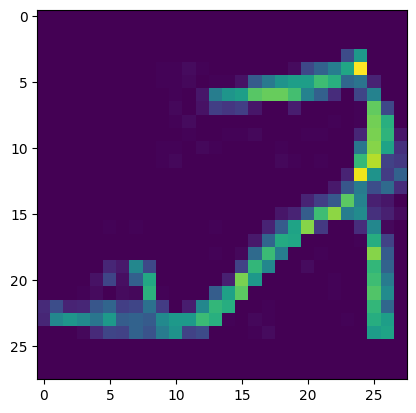

tensor(5)


In [ ]:
for image, label in train_dataset:
    print(image.shape)
    plt.imshow(image.reshape(28, 28))
    plt.show()
    print(label)
    break

In [ ]:
class MyNN(nn.Module):
  def __init__(self,input_dim,num_of_hidden_layers,num_of_neurons_per_layer,output_dim,dropout_rate):
    super().__init__()

    layers=[]
    for i in range(num_of_hidden_layers):
      layers.append(nn.Linear(input_dim,num_of_neurons_per_layer))
      layers.append(nn.BatchNorm1d(num_of_neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim=num_of_neurons_per_layer
    layers.append(nn.Linear(input_dim,output_dim))
    layers.append(nn.Sigmoid())

    self.model=nn.Sequential(*layers)

  def forward(self,X):
    return self.model(X)

In [ ]:
#objective function
def objective(trial):
  num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
  num_neurons_per_layer = trial.suggest_int('num_neurons_per_layer',8,256,16)
  epochs=trial.suggest_int('epochs',10,100,10)
  learning_rate=trial.suggest_float('learning_rate',1e-5,1e-1,log=True)
  dropout_rate=trial.suggest_float('dropout_rate',0.1,0.5,step=0.1)
  batch_size=trial.suggest_int('batch_size',64,512,64)
  optimizer_name=trial.suggest_categorical('optimizer_name', ['SGD', 'Adam', 'RMSprop'])
  weight_decay=trial.suggest_float('weight_decay',1e-4,1e-1,log=True)


  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


  num_of_features = X_train.shape[1]
  output_layer = 10

  model=MyNN(num_of_features,num_hidden_layers,num_neurons_per_layer,output_layer,dropout_rate)
  model=model.to(device)


  loss_fn=nn.CrossEntropyLoss()
  # optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

  if optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  for epoch in range(epochs):

    for images,labels in train_loader:

      images,labels=images.to(device),labels.to(device)

      y_pred=model(images)
      loss=loss_fn(y_pred,labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()


  # model evaluation from here
  model.eval()

  correct=0
  total=0
  with torch.no_grad():
    for images,labels in test_loader:
      images,labels=images.to(device),labels.to(device)
      y_pred=model(images)
      _,predicted=torch.max(y_pred,1)
      total+=labels.shape[0]
      correct+=(predicted==labels).sum().item()

    accuracy = correct/total
  return accuracy


In [ ]:
# !pip install optuna

In [ ]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2025-01-23 05:30:47,939] A new study created in memory with name: no-name-5c85634c-b65b-4be3-bb91-5915abadc40e
<ipython-input-125-df56cfd4514f>:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons_per_layer = trial.suggest_int('num_neurons_per_layer',8,256,16)
<ipython-input-125-df56cfd4514f>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  epochs=trial.suggest_int('epochs',10,100,10)
<ipython-input-125-df56cfd4514f>:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  batch_size=trial.suggest_int('batch_size',64,512,64)
[I 2025-01-23 05:31:23,534] Trial 0 finished with value: 0.8400833333333333 and parameters: {'num_hidden_layers': 2, 'num_neurons_per_layer': 248, 'epochs': 60, 'learning_rate': 0.00038156461133015076, 'dropout_rate': 0.300000000

In [ ]:
study.best_params

{'num_hidden_layers': 2,
 'num_neurons_per_layer': 184,
 'epochs': 80,
 'learning_rate': 0.00014170506438274666,
 'dropout_rate': 0.30000000000000004,
 'batch_size': 512,
 'optimizer_name': 'Adam',
 'weight_decay': 0.0010021100445285784}

In [ ]:
study.best_value

0.8931666666666667

In [ ]:
# model=MyNN(784,3,168,10)
# model=model.to(device)

In [ ]:
correct=0
total=0
with torch.no_grad():
  for images,labels in train_loader:
    images,labels=images.to(device),labels.to(device)
    y_pred=model(images)
    _,predicted=torch.max(y_pred,1)
    total+=labels.shape[0]
    correct+=(predicted==labels).sum().item()

  accuracy = correct/total
  print(accuracy)

0.09285416666666667
